In [ ]:
# MENGHUBUNGKAN COLAB KE GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORT LIBRARY DASAR
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# IMPORT LIBRARY VISUALISASI
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# IMPORT LIBRARY TENSORFLOW & KERAS
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers import RandomZoom, RandomFlip, RandomRotation, RandomHeight, RandomWidth

# IMPORT LIBRARY SISTEM & FILE
from pathlib import Path
import os.path

# IMPORT LIBRARY METRIK EVALUASI
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [ ]:
# Unduh file helper_functions.py menggunakan wget
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import fungsi-fungsi spesifik dari file yang sudah diunduh
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-08-05 16:43:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-05 16:43:08 (95.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Atur Ukuran Batch dan Ukuran Target Gambar
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
# EKSPLORASI & VERIFIKASI STRUKTUR DATASET
dataset = "/content/drive/MyDrive/dataset_gigi_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '/content/drive/MyDrive/dataset_gigi_real'.
There are 0 directories and 2554 images in '/content/drive/MyDrive/dataset_gigi_real/caries'.
There are 0 directories and 2126 images in '/content/drive/MyDrive/dataset_gigi_real/no-caries'.
There are 0 directories and 1131 images in '/content/drive/MyDrive/dataset_gigi_real/bukan-gigi'.


In [ ]:
# MEMBUAT DATAFRAME DARI FILE GAMBAR
# Ubah Path String menjadi Objek Pathlib
image_dir = Path(dataset)

# Kumpulkan Semua Path File Gambar
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

# Ekstrak Label dari Path Folder
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Ubah List menjadi Pandas Series
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Gabungkan Menjadi Satu DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
# VALIDASI & PEMBERSIHAN DATASET
# Import library yang dibutuhkan
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

# Cari semua file berekstensi .jpg secara rekursif
path = Path("/content/drive/MyDrive/dataset_gigi_real").rglob("*.jpg")

# Lakukan perulangan untuk setiap file yang ditemukan
for img_p in path:
    try:
        img = PIL.Image.open(img_p)

# Tangkap error jika file tidak teridentifikasi/korup
    except PIL.UnidentifiedImageError:
            print(img_p)

/tmp/ipython-input-322025102.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


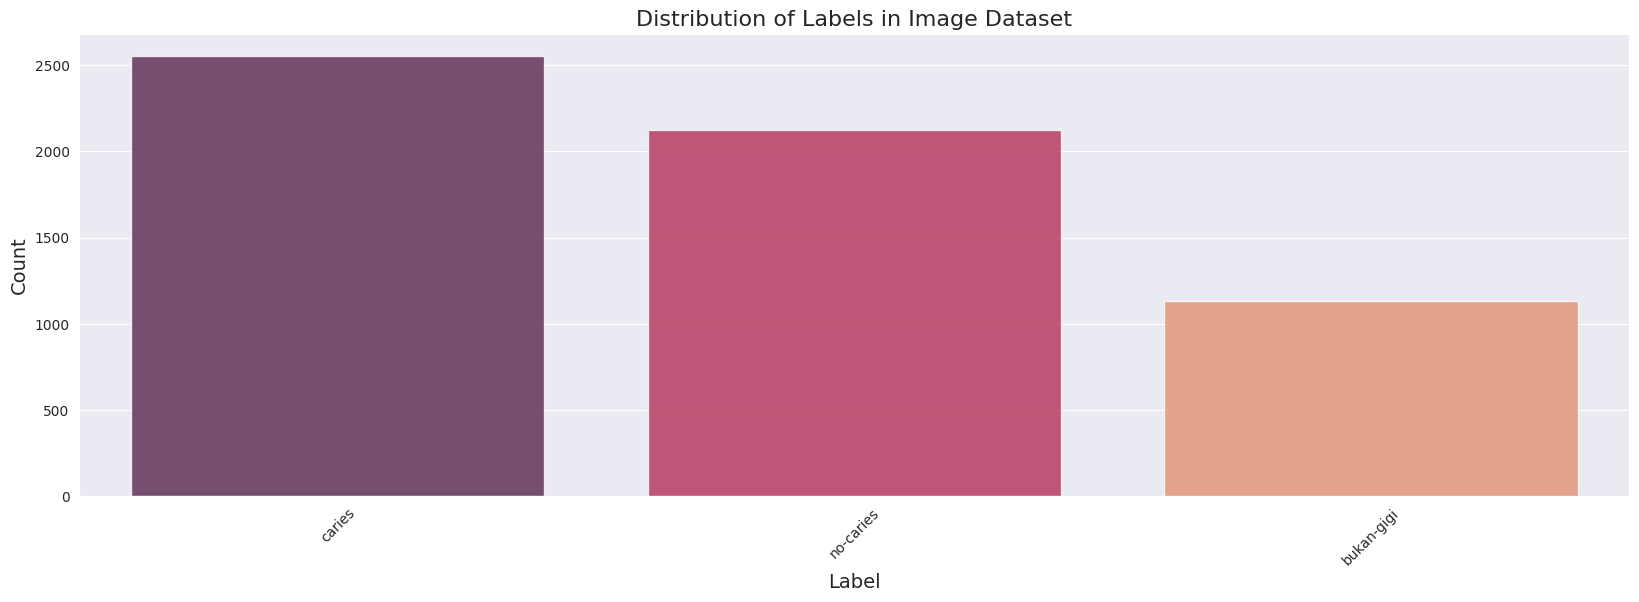

In [ ]:
# VISUALISASI DISTRIBUSI KELAS (LABEL)
# Hitung Jumlah Gambar per Label
label_counts = image_df['Label'].value_counts()

# Atur Ukuran Kanvas Plot
plt.figure(figsize=(20, 6))

# Buat Bar Plot dengan Seaborn
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')

# Atur Judul dan Label Sumbu
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Putar Teks Label di Sumbu-X
plt.xticks(rotation=45)

# Tampilkan Plot
plt.show()

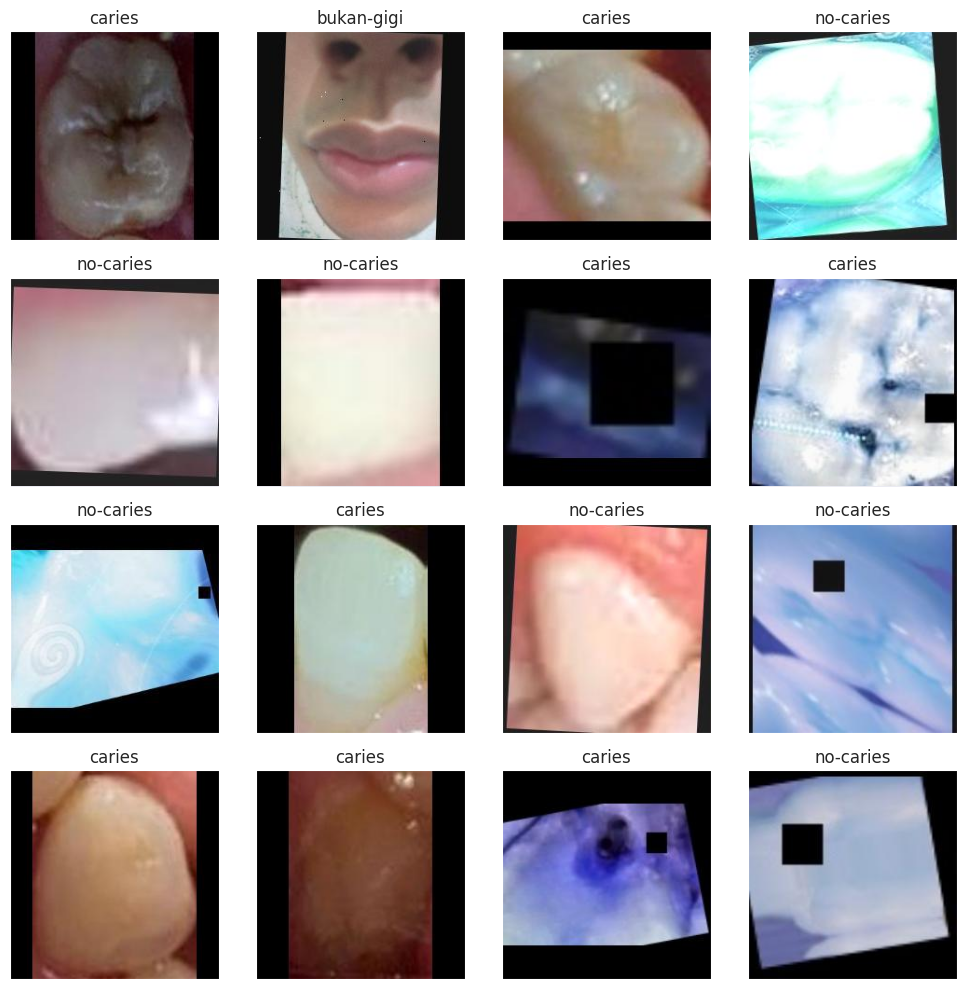

In [ ]:
# MENAMPILKAN CONTOH GAMBAR DARI DATASET
# Pilih 16 Indeks Gambar Secara Acak
random_index = np.random.randint(0, len(image_df), 16)

# Siapkan Grid Subplot 4x4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

# Lakukan Perulangan untuk Mengisi Setiap Subplot
for i, ax in enumerate(axes.flat):

# Tampilkan Gambar Acak di Subplot
ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))

# Tampilkan Label sebagai Judul
ax.set_title(image_df.Label[random_index[i]])

# Rapikan Layout
plt.tight_layout()

# Tampilkan Hasil
plt.show()

In [ ]:
# PEMBAGIAN DATASET (TRAIN-TEST SPLIT)
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
# PERSIAPAN GENERATOR DATA GAMBAR (IMAGE DATA GENERATOR)
# Konfigurasi Generator untuk Data Latih & Validasi
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.1111
)

# Konfigurasi Generator untuk Data Uji
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
)

In [ ]:
# MEMBUAT ALIRAN DATA DARI DATAFRAME
# BUAT GENERATOR UNTUK DATA LATIH (TRAINING)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

# BUAT GENERATOR UNTUK DATA VALIDASI (VALIDATION)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

# BUAT GENERATOR UNTUK DATA UJI (TESTING)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4649 validated image filenames belonging to 3 classes.
Found 580 validated image filenames belonging to 3 classes.
Found 582 validated image filenames belonging to 3 classes.


In [ ]:
# MENGAMBIL NAMA-NAMA KELAS (LABELS)
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['bukan-gigi', 'caries', 'no-caries']


In [ ]:
# MEMBUAT LAPISAN PREPROCESSING (RESIZE & RESCALE)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])

# MEMBUAT LAPISAN AUGMENTASI DATA
data_augmentation = keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
], name="data_augmentation")

In [ ]:
# MEMUAT MODEL PRE-TRAINED (TRANSFER LEARNING)
pretrained_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Bekukan Bobot Model Pre-trained (Freeze Layers)
pretrained_model.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# MEMBUAT CALLBACK UNTUK MENYIMPAN MODEL TERBAIK
# Tentukan Path untuk Menyimpan Checkpoint
checkpoint_path = "classification_model_checkpoint.weights.h5"

# Konfigurasi Callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# MEMBUAT CALLBACK UNTUK MENGHENTIKAN TRAINING LEBIH AWAL
early_stopping = EarlyStopping(monitor="val_loss",
                 patience=5,
                 restore_best_weights=True)

In [ ]:
# MEMBANGUN ARSITEKTUR MODEL AKHIR (FUNCTIONAL API)
# Tentukan Titik Awal dan Akhir dari Model Pre-trained
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

# Tambahkan Hidden Layer Pertama
x = Dense(128, activation='relu')(pretrained_model.output)

# Tambahkan Dropout untuk Regularisasi
x = Dropout(0.2)(x)

# Tambahkan Hidden Layer Kedua
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Tambahkan Output Layer
outputs = Dense(3, activation='softmax')(x)

# Satukan Menjadi Model Akhir
model = Model(inputs=inputs, outputs=outputs)

# MENGKOMPILASI MODEL
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# MENAMPILKAN RINGKASAN ARSITEKTUR MODEL
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,029,875 (3.93 MB)

 Trainable params: 90,755 (354.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# MEMULAI PROSES PELATIHAN MODEL (TRAINING)
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,

# Aktifkan Callbacks
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/classification/20250805-164759


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 62s 338ms/step - accuracy: 0.5350 - loss: 0.9984 - val_accuracy: 0.7672 - val_loss: 0.5644
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.7938 - loss: 0.5273 - val_accuracy: 0.8293 - val_loss: 0.4166
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.8446 - loss: 0.3884 - val_accuracy: 0.8448 - val_loss: 0.3642
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.8643 - loss: 0.3372 - val_accuracy: 0.8724 - val_loss: 0.3212
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8829 - loss: 0.2970 - val_accuracy: 0.8914 - val_loss: 0.2887
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.8919 - loss: 0.2606 - val_accuracy: 0.8897 - val_loss: 0.2786
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9054 - loss: 0.2472 - val_accuracy: 0.9017 - val_loss: 0.2542
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9116 - loss: 0

In [ ]:
# EVALUASI MODEL PADA DATA UJI (TEST SET)
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.15097
Test Accuracy: 93.47%


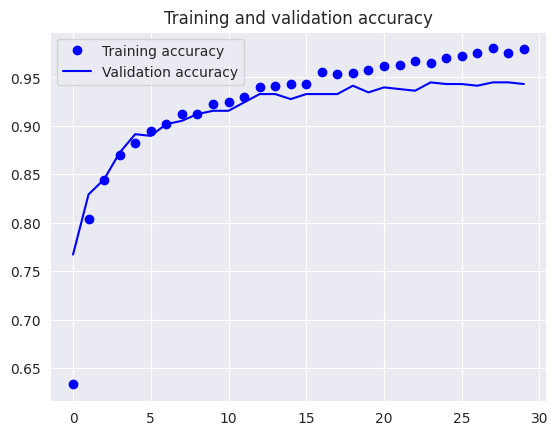

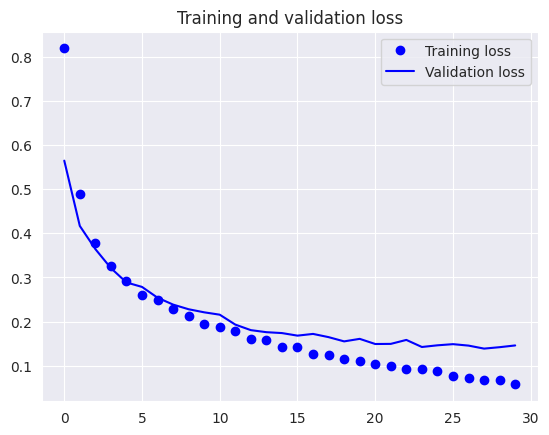

In [ ]:
# VISUALISASI RIWAYAT PELATIHAN (TRAINING HISTORY)
# Ekstrak Data Akurasi dan Loss dari Objek 'history'
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Siapkan Sumbu X (Jumlah Epoch)
epochs = range(len(accuracy))

# Buat Plot untuk Akurasi
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

# Beri Judul dan Legenda pada Plot Akurasi
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

# Tampilkan Semua Plot yang Telah Dibuat
plt.show()

In [ ]:
# MELAKUKAN PREDIKSI & MEMETAKAN HASIL KE LABEL
# Lakukan Prediksi pada Data Uji
pred = model.predict(test_images)

# Ambil Indeks dengan Probabilitas Tertinggi
pred = np.argmax(pred,axis=1)

# Dapatkan pemetaan asli (Nama Kelas -> Indeks)
labels = (train_images.class_indices)

# Balikkan pemetaan menjadi (Indeks -> Nama Kelas)
labels = dict((v,k) for k,v in labels.items())

# Petakan setiap indeks prediksi ke nama labelnya
pred = [labels[k] for k in pred]

# Cetak 5 Hasil Prediksi Pertama
print(f'The first 5 predictions: {pred[:5]}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step
The first 5 predictions: ['bukan-gigi', 'caries', 'caries', 'bukan-gigi', 'caries']


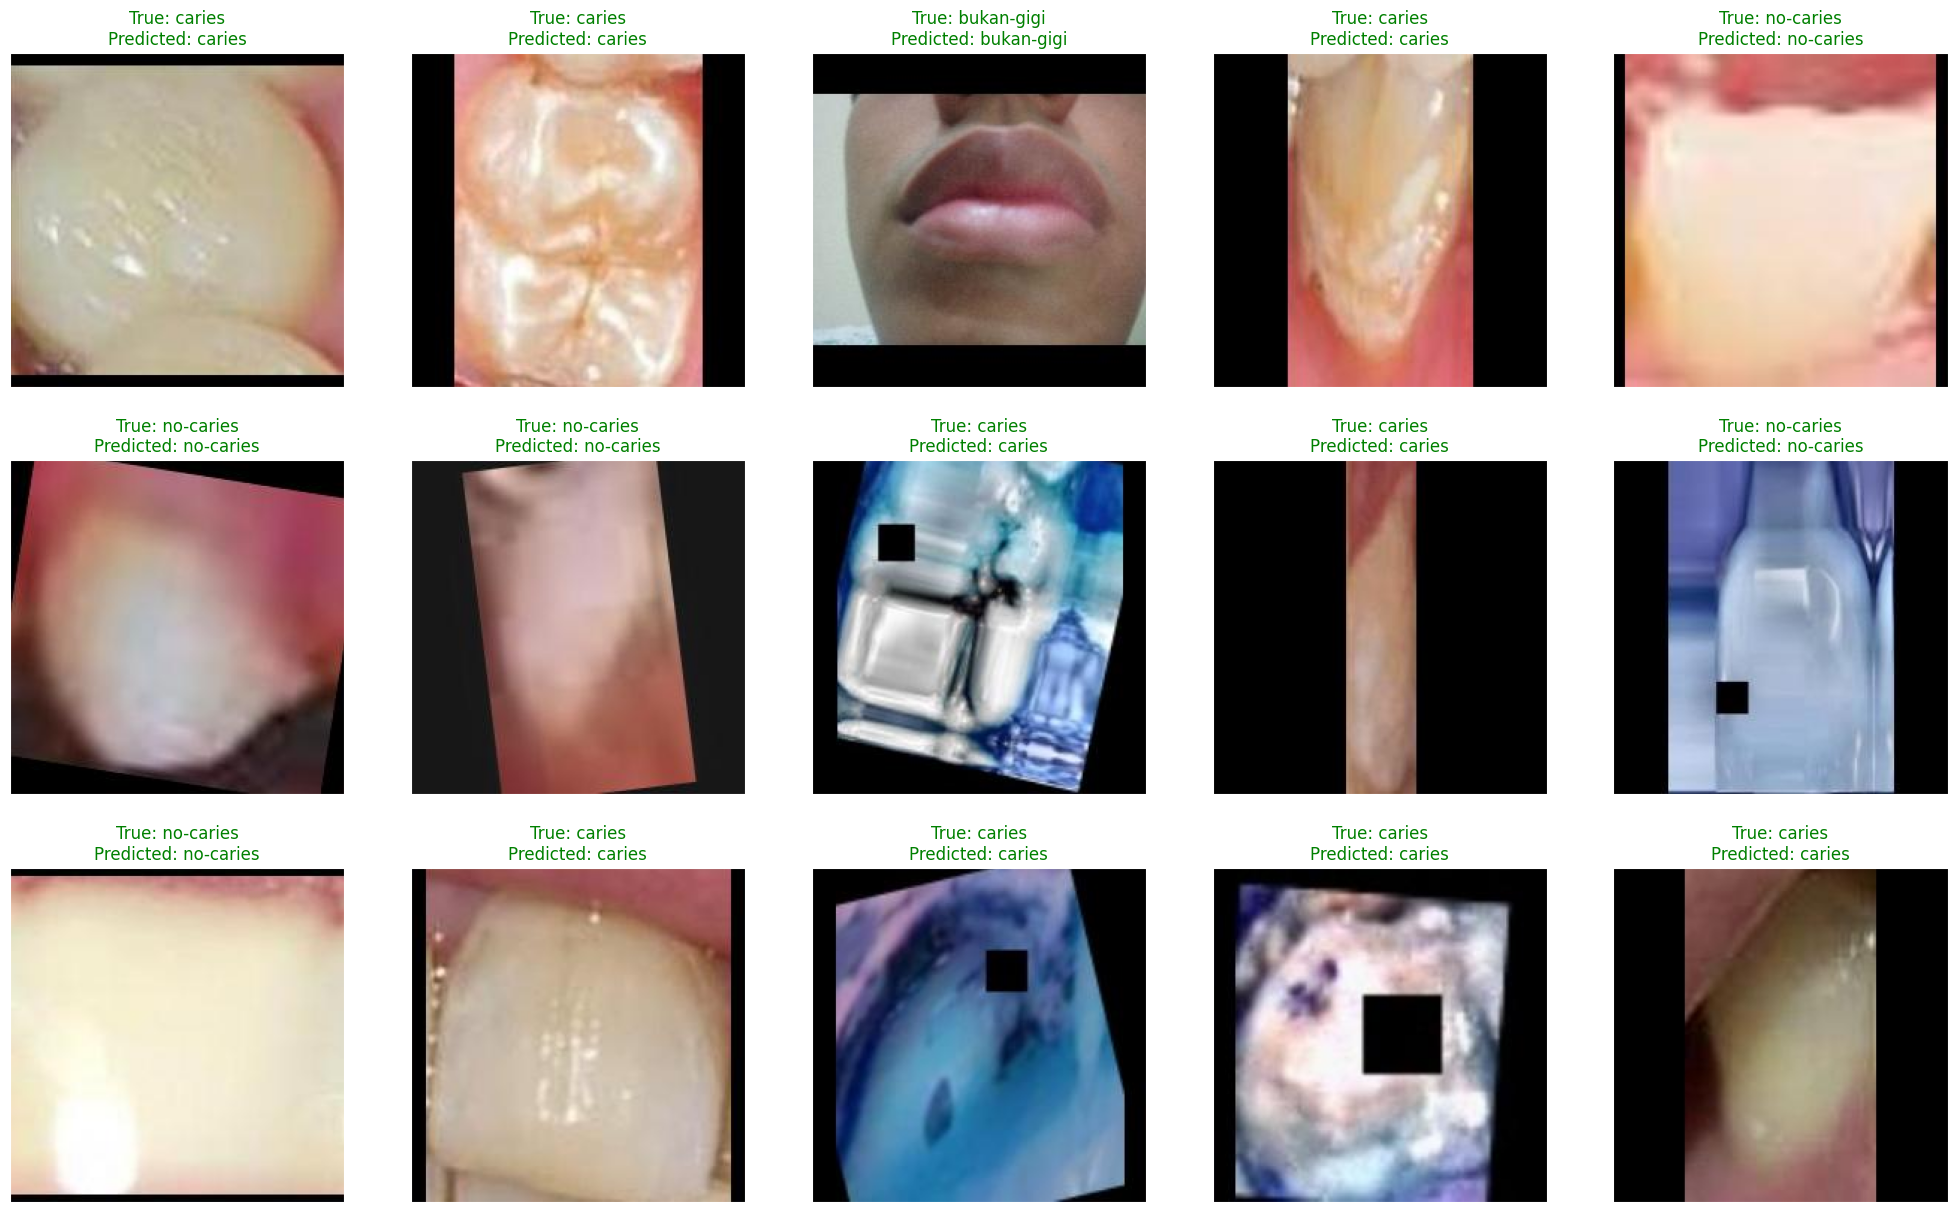

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALISASI HASIL PREDIKSI PADA DATA UJI
# Pilih 15 Indeks Acak dari Data Uji
random_index = np.random.randint(0, len(test_df) - 1, 15)

# Siapkan Grid Subplot 3x5
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

# Lakukan Perulangan untuk Mengisi Setiap Subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

# Tampilkan Keseluruhan Plot
plt.show()
plt.tight_layout()

In [ ]:
# MENAMPILKAN LAPORAN KLASIFIKASI (CLASSIFICATION REPORT)
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

  bukan-gigi       1.00      0.98      0.99       120
      caries       0.92      0.94      0.93       268
   no-caries       0.91      0.90      0.91       194

    accuracy                           0.93       582
   macro avg       0.94      0.94      0.94       582
weighted avg       0.93      0.93      0.93       582



In [ ]:
# MENGUBAH LAPORAN KLASIFIKASI MENJADI DATAFRAME
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
bukan-gigi,1.000000,0.983333,0.991597,120.000000
caries,0.922794,0.936567,0.929630,268.000000
no-caries,0.911458,0.902062,0.906736,194.000000
accuracy,0.934708,0.934708,0.934708,0.934708
macro avg,0.944751,0.940654,0.942654,582.000000
weighted avg,0.934934,0.934708,0.934775,582.000000


In [ ]:
# FUNGSI UNTUK MEMBUAT PLOT CONFUSION MATRIX
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=10, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """

  # LANGKAH 1: HITUNG CONFUSION MATRIX
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # INISIALISASI DAN GAMBAR PLOT
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # ATUR LABEL SUMBU (AXES)
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # LANGKAH 4: TAMBAHKAN TEKS ANOTASI DI SETIAP SEL
  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # LANGKAH 5: SIMPAN GAMBAR
  if savefig:
    fig.savefig("confusion_matrix.png")

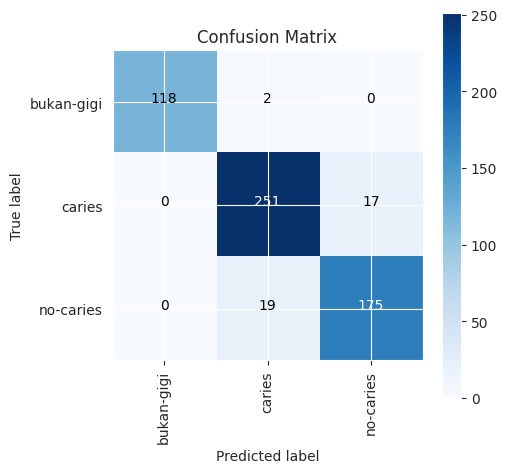

In [ ]:
# MEMANGGIL FUNGSI & MEMBUAT PLOT CONFUSION MATRIX
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
# MENYIMPAN MODEL FINAL KE FILE .KERAS
model.save('dataset_gigi_cnn_tl_real.keras')

In [ ]:
# MENYALIN MODEL FINAL KE GOOGLE DRIVE
from google.colab import drive

drive.mount('/content/drive')
!cp dataset_gigi_cnn_tl_real.keras /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# MENGUNDUH FILE MODEL KE KOMPUTER LOKAL
from google.colab import files
files.download('dataset_gigi_cnn_tl_real.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>